# Adversarial Regularization for 1D CNN Toy Model

#### Adapted from tensorflow Adversarial Regularization for Image Classification tutorial:

https://www.tensorflow.org/neural_structured_learning/tutorials/adversarial_keras_cnn_mnist

[github](https://github.com/tensorflow/neural-structured-learning/blob/master/g3doc/tutorials/adversarial_keras_cnn_mnist.ipynb)



## Setup

Install the Neural Structured Learning package.

In [1]:
import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf

plt.rcParams['figure.dpi'] = 90

In [2]:
print('TensorFlow Version {}'.format(tf.__version__))

TensorFlow Version 2.4.1


## Hyperparameters


Hyperparamaters explanations from https://www.tensorflow.org/neural_structured_learning/tutorials/adversarial_keras_cnn_mnist


Input/Output:

*   **`input_shape`**: The shape of the input tensor. Each image is 28-by-28
pixels with 1 channel.
*   **`num_classes`**: There are a total of 10 classes, corresponding to 10
digits [0-9].

Model architecture:

*   **`conv_filters`**: A list of numbers, each specifying the number of
filters in a convolutional layer.
*   **`kernel_size`**: The size of 2D convolution window, shared by all
convolutional layers.
*   **`pool_size`**: Factors to downscale the image in each max-pooling layer.
*   **`num_fc_units`**: The number of units (i.e., width) of each
fully-connected layer.

Training and evaluation:

*  **`batch_size`**: Batch size used for training and evaluation.
*  **`epochs`**: The number of training epochs.

Adversarial learning:

*   **`adv_multiplier`**: The weight of adversarial loss in the training
objective, relative to the labeled loss.
*   **`adv_step_size`**: The magnitude of adversarial perturbation.
*  **`adv_grad_norm`**: The norm to measure the magnitude of adversarial
perturbation.


In [3]:
# this notebook does note use any hyperparameters to make the base model

class HParams(object):
    def __init__(self):
#         self.input_shape = [10, 1]
#         self.num_classes = 10
#         self.conv_filters = [64, 3]
#         self.kernel_size = (3)
#         self.pool_size = (2)
#         self.num_fc_units = [10]
#         self.batch_size = 20
        self.epochs = 10
        self.adv_multiplier = 1.0
        self.adv_step_size = 2
        self.adv_grad_norm = 'infinity'

HPARAMS = HParams()

## Functions

In [4]:
def getLabels(array):
    return np.array(array[-1], dtype=float)

In [5]:


# FEATURE_INPUT_NAME = ['pt', 'eta', 'phi', 'mass', 'thetalab', 'radiilab', 'zlab']
FEATURE_INPUT_NAME = ['pt', 'thetalab']
LABEL_INPUT_NAME = 'labels'

## Load Perturbed and Un-perturbed samples

npz files are output of `UBCMS-XAI/AdversarialNetworks/ToyModel/makeFourVectors.ipynb`

In [6]:
# perturbed samples
perturbed_data_train = np.load('data/jetConstTrain_overlap_perturb.npz')
perturbed_data_test = np.load('data/jetConstTest_overlap_perturb.npz')
perturbed_batch = len(perturbed_data_train['pt'])
perturbed_feat_all = [key for key in perturbed_data_train.keys()]
perturbed_feat_all.remove('labels')
print('Perturbed dataset features:')
print(perturbed_feat_all)
print()

Perturbed dataset features:
['pt', 'eta', 'phi', 'mass', 'thetalab', 'radiilab', 'zlab']



In [7]:
# un-perturbed samples
data_train = np.load('data/jetConstTrain_overlap.npz')
data_test = np.load('data/jetConstTest_overlap.npz')
batch = len(data_train['pt'])
feat_all = [key for key in data_train.keys()]
feat_all.remove('labels')
print('Un-perturbed dataset features:')
print(feat_all)
print()

Un-perturbed dataset features:
['pt', 'eta', 'phi', 'mass', 'thetalab', 'radiilab', 'zlab']



## Create perturbed dataset dictionaries and lists

In [8]:
perturbed_data_train_dict = {}
perturbed_data_test_dict  = {}

for key in perturbed_data_train.keys():
    if not 'labels' in key:
        perturbed_data_train_dict[key] = perturbed_data_train[key].reshape(20000, 10, 1)
        perturbed_data_test_dict[key] = perturbed_data_test[key].reshape(20000, 10, 1)

perturbed_data_train_dict['labels'] = perturbed_data_train['labels'][:,1]
perturbed_data_test_dict['labels'] = perturbed_data_test['labels'][:,1]


perturbed_data_train_list = [perturbed_data_train_dict[key] for key in FEATURE_INPUT_NAME+[LABEL_INPUT_NAME]]
perturbed_data_test_list  = [perturbed_data_test_dict[key]  for key in FEATURE_INPUT_NAME+[LABEL_INPUT_NAME]]



## Create un-perturbed dataset dictionaries and lists

In [9]:
data_train_dict = {}
data_test_dict  = {}

for key in FEATURE_INPUT_NAME+[LABEL_INPUT_NAME]:
    if not 'labels' in key:
        data_train_dict[key] = data_train[key].reshape(20000, 10, 1)
        data_test_dict[key] = data_test[key].reshape(20000, 10, 1)

data_train_dict['labels'] = data_train['labels'][:,1]
data_test_dict['labels'] = data_test['labels'][:,1]
        

data_train_dict_subset = {key: data_train_dict[key] for key in FEATURE_INPUT_NAME+[LABEL_INPUT_NAME]}
data_test_dict_subset  = {key: data_test_dict[key]  for key in FEATURE_INPUT_NAME+[LABEL_INPUT_NAME]}

data_train_list = [data_train_dict[key] for key in FEATURE_INPUT_NAME+[LABEL_INPUT_NAME]]
data_test_list  = [data_test_dict[key]  for key in FEATURE_INPUT_NAME+[LABEL_INPUT_NAME]]



In [10]:
getLabels(data_train_list).shape

(20000,)

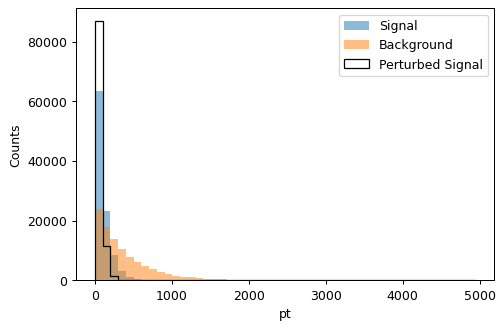

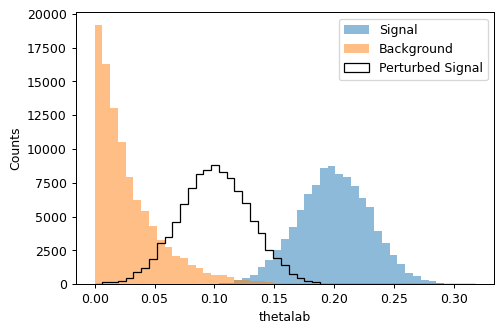

In [11]:
sig_true = (getLabels(data_train_list) == 1)
bkg_true = (getLabels(data_train_list) == 0)
sig_pert = (getLabels(perturbed_data_train_list) == 1)

for i, (feature, perturbed_feature) in enumerate(zip(data_train_list, perturbed_data_train_list)):
    
    if(i == len(perturbed_data_train_list) - 1): continue

    bmax = np.max(feature.flatten())
    bmin = np.min(feature.flatten())
    
    plt.hist(feature[sig_true].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5, label='Signal')
    plt.hist(feature[bkg_true].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5, label='Background')
    plt.hist(perturbed_feature[sig_pert].flatten(), bins=np.linspace(bmin, bmax, 50), color='k', histtype='step', label='Perturbed Signal')
    plt.xlabel(FEATURE_INPUT_NAME[i])
    plt.ylabel('Counts')
    plt.legend()
    plt.show()

## Base model


In [12]:
def build_base_model():


    input_shape = (10, 1)
    inputs = [tf.keras.Input(shape=input_shape, dtype=tf.float32, name=name) for name in FEATURE_INPUT_NAME]
    print(inputs)
    
    x = tf.keras.layers.concatenate(inputs = [*inputs], axis=-1, name = 'concat')
    
    print(x)
    
    x = tf.keras.layers.Conv1D(64, 3, padding = 'same', activation='relu', name = 'conv1')(x)
    x = tf.keras.layers.Conv1D(64, 1, padding = 'same', activation='relu', name = 'conv2')(x)
    x = tf.keras.layers.MaxPool1D(2)(x)
    x = tf.keras.layers.Conv1D(32, 3, padding = 'same', activation='relu', name = 'conv3')(x)
    x = tf.keras.layers.Conv1D(32, 1, padding = 'same', activation='relu', name = 'conv4')(x)
    x = tf.keras.layers.MaxPool1D(2)(x)
    x = tf.keras.layers.Flatten(name = 'flatten')(x)
    x = tf.keras.layers.Dense(64, activation='relu', name = 'relu')(x)
    pred = tf.keras.layers.Dense(2, activation='softmax', name = 'output')(x) 
    model = tf.keras.Model(inputs=[*inputs], outputs=pred)

    return model


In [13]:
base_model = build_base_model()
base_model.summary()

[<KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'pt')>, <KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'thetalab')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 10, 2), dtype=tf.float32, name=None), name='concat/concat:0', description="created by layer 'concat'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pt (InputLayer)                 [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
thetalab (InputLayer)           [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 10, 2)        0           pt[0][0]              

### Train and evaluate the model on perturbed dataset

In [14]:
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])

base_model.fit(perturbed_data_train_list[:-1], getLabels(perturbed_data_train_list), epochs=HPARAMS.epochs)


Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4063 - acc: 0.8162
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0196 - acc: 0.9948
Epoch 3/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0122 - acc: 0.9964
Epoch 4/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0083 - acc: 0.9977
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0057 - acc: 0.9977
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0053 - acc: 0.9986
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0068 - acc: 0.9979
Epoch 8/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0042 - acc: 0.9986
Epoch 9/10
625/625 [==============================] - 2s 3ms/step - loss: 0.0054 - acc: 0.9981
Epoch 10/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0049 - acc: 0.9984


In [15]:

results = base_model.evaluate(perturbed_data_test_list[:-1], getLabels(perturbed_data_test_list))
named_results = dict(zip(base_model.metrics_names, results))
print('\naccuracy:', named_results['acc'])

625/625 [==============================] - 1s 2ms/step - loss: 0.0029 - acc: 0.9994

accuracy: 0.9994000196456909


## Adversarial-regularized model


In [16]:
base_adv_model = build_base_model()
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys = ['labels']
)

[<KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'pt')>, <KerasTensor: shape=(None, 10, 1) dtype=float32 (created by layer 'thetalab')>]
KerasTensor(type_spec=TensorSpec(shape=(None, 10, 2), dtype=tf.float32, name=None), name='concat/concat:0', description="created by layer 'concat'")


In [17]:
adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['acc'])


adv_model.fit(perturbed_data_train_dict, epochs=HPARAMS.epochs)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fd8975f3110> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fd8975f3110> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <cyfunction Socket.send at 0x7fd8975f3110> is not a module, class, method, function, traceback, frame, or code object
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


625/625 [==============================] - 12s 5ms/step - loss: 0.5658 - sparse_categorical_crossentropy: 0.4715 - sparse_categorical_accuracy: 0.8201 - scaled_adversarial_loss: 0.0943
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0265 - sparse_categorical_crossentropy: 0.0221 - sparse_categorical_accuracy: 0.9946 - scaled_adversarial_loss: 0.0044
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0195 - sparse_categorical_crossentropy: 0.0162 - sparse_categorical_accuracy: 0.9956 - scaled_adversarial_loss: 0.0033
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0081 - sparse_categorical_crossentropy: 0.0068 - sparse_categorical_accuracy: 0.9980 - scaled_adversarial_loss: 0.0014
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0117 - sparse_categorical_crossentropy: 0.0098 - sparse_categorical_accuracy: 0.9973 - scaled_adversarial_loss: 0.0020
Epoch 6/10
625/625 [===============

In [18]:
results = adv_model.evaluate(perturbed_data_test_dict)
named_results = dict(zip(adv_model.metrics_names, results))
print('\naccuracy:', named_results['sparse_categorical_accuracy'])

625/625 [==============================] - 2s 3ms/step - loss: 0.0039 - sparse_categorical_crossentropy: 0.0033 - sparse_categorical_accuracy: 0.9989 - scaled_adversarial_loss: 6.5837e-04

accuracy: 0.9988999962806702


## Evaluate models with un-perturbed datasets

In [19]:
adv_config= nsl.configs.make_adv_reg_config(
    multiplier=HPARAMS.adv_multiplier,
    adv_step_size=HPARAMS.adv_step_size,
    adv_grad_norm=HPARAMS.adv_grad_norm
)

In [20]:
reference_model = nsl.keras.AdversarialRegularization(
    base_model,
    label_keys = ['labels'],
    adv_config=adv_config
)
reference_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc'])

In [21]:
models_to_eval = {
    'base': base_model,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

In [22]:
pred_cut = 0.6
predictions = []
predictions.append({})


perturbed_batch = [pbatch[:200] for pbatch in perturbed_data_test_list[:-1]]

sample_batch = [sbatch[:200] for sbatch in data_test_list[:-1]]


y_true = np.array(perturbed_batch)
    
for name, model in models_to_eval.items():
    print('evaluating {0} model'.format(name))
    y_pred = model(data_test_dict)

    metrics[name](y_true, y_pred)
    
    y = np.where(y_pred[:,1] > pred_cut, 1, 0)
    predictions[-1][name] = y
    

evaluating base model


/usr/local/jupyter/lib64/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


evaluating adv-regularized model


In [23]:
plt.rcParams['figure.dpi'] = 100

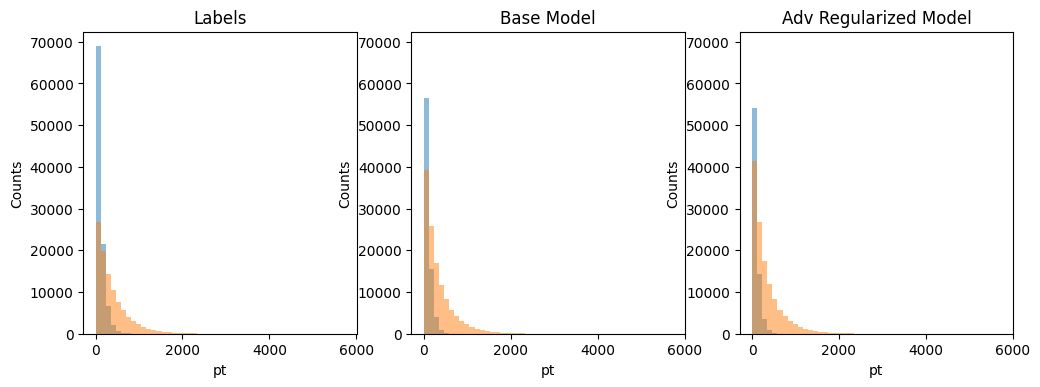

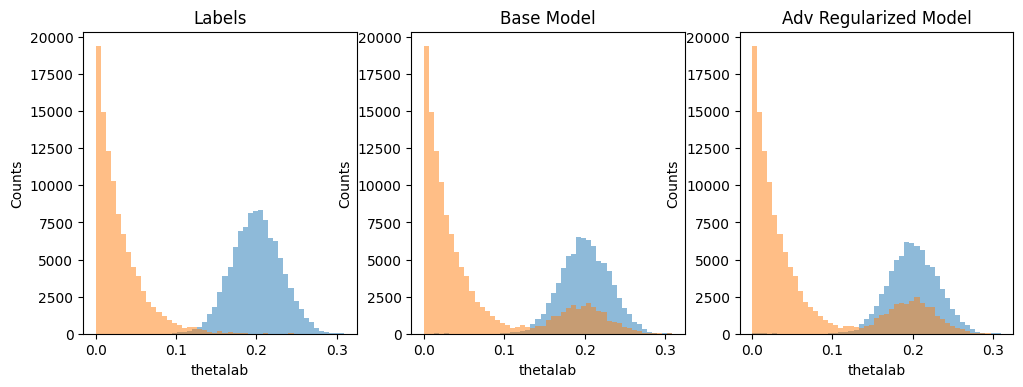

In [24]:


batch_index = slice(0,200)
    
n_col = 3
n_row = 1

labels =  getLabels(data_test_list)

sig_true = (labels == 1)
bkg_true = (labels == 0)



sig_base = (predictions[0]['base'] == 1)
bkg_base = (predictions[0]['base'] == 0)

sig_adv = (predictions[0]['adv-regularized'] == 1)
bkg_adv = (predictions[0]['adv-regularized'] == 0)

for i, feature in enumerate(data_test_list):
    if(i==len(data_test_list)-1):continue
    

    fig, ax = plt.subplots(n_row, n_col, figsize=(12, 4) )
    bmax = np.max(feature.flatten())
    bmin = np.min(feature.flatten())
    
    ax[0].hist(feature[sig_true].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[0].hist(feature[bkg_true].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[0].set_xlabel(FEATURE_INPUT_NAME[i])
    ax[0].set_ylabel('Counts')
    ax[0].set_title('Labels')
    ylim = ax[0].get_ylim()

    ax[1].hist(feature[sig_base].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[1].hist(feature[bkg_base].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[1].set_xlabel(FEATURE_INPUT_NAME[i])
    ax[1].set_ylabel('Counts')
    ax[1].set_title('Base Model')
    ax[1].set_ylim(ylim)
    
    ax[2].hist(feature[sig_adv].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[2].hist(feature[bkg_adv].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[2].set_xlabel(FEATURE_INPUT_NAME[i])
    ax[2].set_ylabel('Counts')
    ax[2].set_title('Adv Regularized Model')
    ax[2].set_ylim(ylim)
    plt.show()



### Correctly Predicted Events

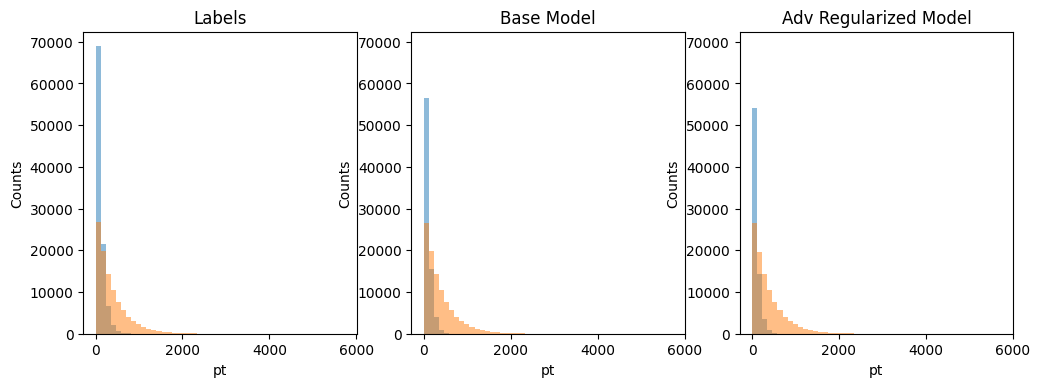

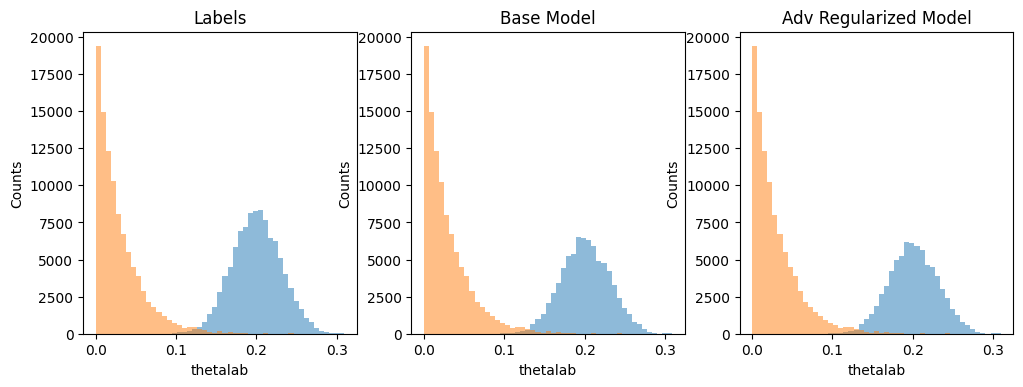

In [25]:
for i, feature in enumerate(data_test_list):
    if(i==len(data_test_list)-1):continue
    

    fig, ax = plt.subplots(n_row, n_col, figsize=(12, 4) )
    bmax = np.max(feature.flatten())
    bmin = np.min(feature.flatten())
    
    ax[0].hist(feature[sig_true].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[0].hist(feature[bkg_true].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[0].set_xlabel(FEATURE_INPUT_NAME[i])
    ax[0].set_ylabel('Counts')
    ax[0].set_title('Labels')
    ylim = ax[0].get_ylim()

    ax[1].hist(feature[sig_base & sig_true].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[1].hist(feature[bkg_base & bkg_true].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[1].set_xlabel(FEATURE_INPUT_NAME[i])
    ax[1].set_ylabel('Counts')
    ax[1].set_title('Base Model')
    ax[1].set_ylim(ylim)
    
    ax[2].hist(feature[sig_adv & sig_true].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[2].hist(feature[bkg_adv & bkg_true].flatten(), bins=np.linspace(bmin, bmax, 50), alpha=0.5)
    ax[2].set_xlabel(FEATURE_INPUT_NAME[i])
    ax[2].set_ylabel('Counts')
    ax[2].set_title('Adv Regularized Model')
    ax[2].set_ylim(ylim)
    plt.show()


In [26]:
true_sig = len(sig_true[sig_true & sig_true])
true_bkg = len(bkg_true[bkg_true & bkg_true])

true_base_sig = len(sig_true[sig_true & sig_base])
true_base_bkg = len(bkg_true[bkg_true & bkg_base])

true_adv_sig = len(sig_true[sig_true & sig_adv])
true_adv_bkg = len(bkg_true[bkg_true & bkg_adv])

print()
print('Total Labels', true_sig + true_bkg)
print('Total Correctly Predicted Base Model', true_base_sig + true_base_bkg)
print('Total Correctly Predicted Adv Model ', true_adv_sig + true_adv_bkg)
print()
print('True Signal', true_sig)
print('Correctly Predicted Signal, Base Model', true_base_sig)
print('Correctly Predicted Signal, Adv Model ', true_adv_sig)
print()
print('True Background', true_bkg)
print('Correctly Predicted Background, Base Model', true_base_bkg)
print('Correctly Predicted Background, Adv Model ', true_adv_bkg)





Total Labels 20000
Total Correctly Predicted Base Model 17667
Total Correctly Predicted Adv Model  17282

True Signal 10000
Correctly Predicted Signal, Base Model 7679
Correctly Predicted Signal, Adv Model  7295

True Background 10000
Correctly Predicted Background, Base Model 9988
Correctly Predicted Background, Adv Model  9987


### ROC / AUC curves

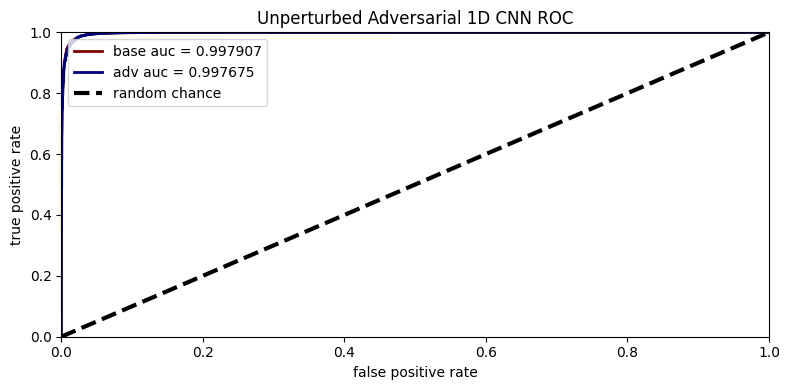

In [27]:
# Plot ROC

basemodel = base_model
advmodel = models_to_eval['adv-regularized']

base_predict = basemodel.predict(data_test_dict)
adv_predict = advmodel.predict(data_test_dict)

from sklearn.metrics import roc_curve, auc

# Note that getLabels(data_test_list) returns the binary needed for roc curves.
# p -> perturbed, u -> unperturbed
ufpr, utpr, uthresholds = roc_curve(getLabels(data_test_list), base_predict[:][:,1])
pfpr, ptpr, pthresholds = roc_curve(getLabels(data_test_list), adv_predict[:][:,1])

# Get the roc/auc curves:
uroc_auc = auc(ufpr, utpr)
proc_auc = auc(pfpr, ptpr)

fig, axs = plt.subplots(1, 1, figsize = (8, 4))

axs.plot(ufpr, utpr, lw = 2, color = 'maroon', label = 'base auc = {:3f}'.format(uroc_auc))
axs.plot(pfpr, ptpr, lw = 2, color = 'navy', label = 'adv auc = {:3f}'.format(proc_auc))

axs.plot([0, 1], [0, 1], linestyle='--', lw = 3, color ='k', label='random chance')

axs.set_xlim([0, 1.0])
axs.set_ylim([0, 1.0])

axs.set_xlabel('false positive rate')
axs.set_ylabel('true positive rate')
axs.set_title('Unperturbed Adversarial 1D CNN ROC')

axs.legend(loc="upper left")

fig.tight_layout()
fig.savefig('unperturbed_adv_1dcnn.png')

/usr/local/jupyter/lib64/python3.6/site-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['eta', 'phi', 'mass', 'radiilab', 'zlab', 'labels'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


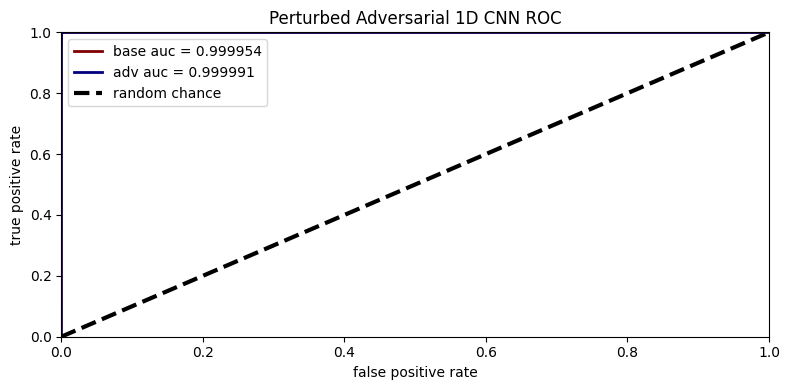

In [28]:
# Plot ROC

basemodel = base_model
advmodel = models_to_eval['adv-regularized']

base_predict = basemodel(perturbed_data_test_dict)
adv_predict = advmodel(perturbed_data_test_dict)

from sklearn.metrics import roc_curve, auc

# Note that getLabels(data_test_list) returns the binary needed for roc curves.
# p -> perturbed, u -> unperturbed
ufpr, utpr, uthresholds = roc_curve(getLabels(perturbed_data_test_list), base_predict[:][:,1])
pfpr, ptpr, pthresholds = roc_curve(getLabels(perturbed_data_test_list), adv_predict[:][:,1])

# Get the roc/auc curves:
uroc_auc = auc(ufpr, utpr)
proc_auc = auc(pfpr, ptpr)

fig, axs = plt.subplots(1, 1, figsize = (8, 4))

axs.plot(ufpr, utpr, lw = 2, color = 'maroon', label = 'base auc = {:3f}'.format(uroc_auc))
axs.plot(pfpr, ptpr, lw = 2, color = 'navy', label = 'adv auc = {:3f}'.format(proc_auc))

axs.plot([0, 1], [0, 1], linestyle='--', lw = 3, color ='k', label='random chance')

axs.set_xlim([0, 1.0])
axs.set_ylim([0, 1.0])

axs.set_xlabel('false positive rate')
axs.set_ylabel('true positive rate')
axs.set_title('Perturbed Adversarial 1D CNN ROC')

axs.legend(loc="upper left")

fig.tight_layout()
fig.savefig('perturbed_adv_1dcnn.png')